# 🎥 Mineração de Texto em Comentários do YouTube  
## Análise de Sentimentos com VADER e BERT (Notebook Final)

**Disciplina:** Mineração de Texto  
**Tema:** Análise de sentimentos em comentários de vídeos do YouTube  
**Autor:** Renan Ost

Este notebook consolida o fluxo final do projeto de mineração de textos em comentários de vídeos do YouTube.

In [1]:
import os
import re
import string
import logging
from datetime import datetime
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Tentar importar VADER
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
    logger.info("✓ VADER importado com sucesso")
except ImportError:
    VADER_AVAILABLE = False
    logger.warning("⚠ VADER não disponível - instale: pip install vaderSentiment")

# Tentar importar BERT
try:
    from transformers import pipeline
    BERT_AVAILABLE = True
    logger.info("✓ BERT importado com sucesso")
except ImportError:
    BERT_AVAILABLE = False
    logger.warning("⚠ BERT não disponível - instale: pip install transformers torch")

# Configurações de visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Diretórios
DATA_DIR = "data"
RESULTADOS_DIR = "resultados"
os.makedirs(RESULTADOS_DIR, exist_ok=True)

logger.info("Imports concluídos com sucesso")

2025-11-23 19:00:03,271 - WARNING - ⚠ VADER não disponível - instale: pip install vaderSentiment
c:\Users\renan\OneDrive\Desktop\youtube-sentiment-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\renan\OneDrive\Desktop\youtube-sentiment-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-23 19:00:26,549 - INFO - ✓ BERT importado com sucesso
2025-11-23 19:00:26,577 - INFO - Imports concluídos com sucesso
2025-11-23 19:00:26,549 - INFO - ✓ BERT importado com sucesso
2025-11-23 19:00:26,577 - INFO - Imports concluídos com sucesso


In [2]:
def carregar_ultimo_csv(padrao: str) -> pd.DataFrame:
    """
    Carrega o CSV mais recente que corresponde ao padrão especificado.
    
    Args:
        padrao: Padrão glob para buscar arquivos (ex: "data/*.csv")
        
    Returns:
        DataFrame com os dados carregados
        
    Raises:
        FileNotFoundError: Se nenhum arquivo corresponder ao padrão
    """
    arquivos = glob(padrao)
    
    if not arquivos:
        msg = f"Nenhum CSV encontrado com padrão: {padrao}"
        logger.error(msg)
        raise FileNotFoundError(msg)
    
    ultimo = sorted(arquivos)[-1]
    logger.info(f"Carregando arquivo: {ultimo}")
    
    df = pd.read_csv(ultimo)
    logger.info(f"✓ Carregados {len(df)} registros")
    
    return df

# Carregar dados
PADRAO = os.path.join(DATA_DIR, "comentarios_coletados_*.csv")

try:
    df_raw = carregar_ultimo_csv(PADRAO)
except FileNotFoundError as e:
    logger.error(f"Erro ao carregar dados: {e}")
    df_raw = pd.DataFrame()

logger.info(f"Primeiras linhas do dataset:\n{df_raw.head()}")

2025-11-23 19:00:26,670 - INFO - Carregando arquivo: data\comentarios_coletados_20251123_185144.csv
2025-11-23 19:00:26,743 - INFO - ✓ Carregados 4372 registros
2025-11-23 19:00:26,760 - INFO - Primeiras linhas do dataset:
      video_id                                 video_titulo  \
0  VKf6NF0OD5A  The new and improved YouTube Studio is here   
1  VKf6NF0OD5A  The new and improved YouTube Studio is here   
2  VKf6NF0OD5A  The new and improved YouTube Studio is here   
3  VKf6NF0OD5A  The new and improved YouTube Studio is here   
4  VKf6NF0OD5A  The new and improved YouTube Studio is here   

                                          comentario      idioma data_coleta  
0  Check out the entire series on how to use YouT...          en  2025-11-23  
1             Thank you youtube for 300 subscribe 🙏🙏          en  2025-11-23  
2                                               ❤🎉🎉🎉  indefinido  2025-11-23  
3        Thank you youtube for 110 subscribers  🙏 ❤❤          en  2025-11-23  
4  

In [3]:
def limpar_texto(texto: str) -> str:
    """
    Limpa e normaliza texto removendo URLs, menções, números e pontuação.
    
    Args:
        texto: Texto a ser limpo
        
    Returns:
        Texto limpo e normalizado em minúsculas
    """
    if pd.isna(texto):
        return ""
    
    texto = str(texto)
    
    # Remover URLs
    texto = re.sub(r"http\S+|www\.\S+", " ", texto)
    
    # Remover menções e hashtags
    texto = re.sub(r"[@#]\w+", " ", texto)
    
    # Remover números
    texto = re.sub(r"\d+", " ", texto)
    
    # Remover pontuação
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    
    # Remover espaços extras
    texto = re.sub(r"\s+", " ", texto).strip()
    
    return texto.lower()

# Processar dados
if not df_raw.empty:
    # Detectar coluna de texto
    COLUNAS_POSSIVEIS = ["comentario", "comentário", "comment", "texto", "text"]
    COL_TEXTO = None
    
    for col in COLUNAS_POSSIVEIS:
        if col in df_raw.columns:
            COL_TEXTO = col
            logger.info(f"Coluna de texto detectada: '{COL_TEXTO}'")
            break
    
    if COL_TEXTO is None:
        logger.error(f"Nenhuma coluna de texto encontrada. Colunas disponíveis: {df_raw.columns.tolist()}")
        df = df_raw.copy()
    else:
        df = df_raw.copy()
        
        # Verificar duplicatas
        duplicatas = df.duplicated(subset=[COL_TEXTO]).sum()
        logger.info(f"Duplicatas encontradas: {duplicatas}")
        
        # Preservar original e criar versão limpa
        df["texto_original"] = df[COL_TEXTO]
        df["texto_limpo"] = df[COL_TEXTO].apply(limpar_texto)
        
        # Verificar textos vazios após limpeza
        vazios = (df["texto_limpo"].str.len() == 0).sum()
        logger.warning(f"Textos vazios após limpeza: {vazios}")
        
        logger.info(f"✓ Limpeza de texto concluída")
else:
    logger.warning("DataFrame vazio - não há dados para processar")
    df = df_raw.copy()

df.head()

2025-11-23 19:00:26,783 - INFO - Coluna de texto detectada: 'comentario'
2025-11-23 19:00:26,793 - INFO - Duplicatas encontradas: 225
2025-11-23 19:00:26,793 - INFO - Duplicatas encontradas: 225
2025-11-23 19:00:26,911 - WARNING - Textos vazios após limpeza: 76
2025-11-23 19:00:26,912 - INFO - ✓ Limpeza de texto concluída
2025-11-23 19:00:26,911 - WARNING - Textos vazios após limpeza: 76
2025-11-23 19:00:26,912 - INFO - ✓ Limpeza de texto concluída


,video_id,video_titulo,comentario,idioma,data_coleta,texto_original,texto_limpo
0,VKf6NF0OD5A,The new and improved YouTube Studio is here,Check out the entire series on how to use YouT...,en,2025-11-23,Check out the entire series on how to use YouT...,check out the entire series on how to use yout...
1,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 300 subscribe 🙏🙏,en,2025-11-23,Thank you youtube for 300 subscribe 🙏🙏,thank you youtube for subscribe 🙏🙏
2,VKf6NF0OD5A,The new and improved YouTube Studio is here,❤🎉🎉🎉,indefinido,2025-11-23,❤🎉🎉🎉,❤🎉🎉🎉
3,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 110 subscribers 🙏 ❤❤,en,2025-11-23,Thank you youtube for 110 subscribers 🙏 ❤❤,thank you youtube for subscribers 🙏 ❤❤
4,VKf6NF0OD5A,The new and improved YouTube Studio is here,Goooodd❤❤❤ 0:14,so,2025-11-23,Goooodd❤❤❤ 0:14,goooodd❤❤❤


In [4]:
def aplicar_vader(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica análise de sentimentos VADER ao DataFrame.
    
    Args:
        df: DataFrame com coluna 'texto_limpo'
        
    Returns:
        DataFrame com colunas vader_compound e vader_label adicionadas
    """
    if not VADER_AVAILABLE:
        logger.warning("VADER não disponível - adicionando colunas com valores padrão")
        df["vader_compound"] = np.nan
        df["vader_label"] = "indefinido"
        return df
    
    try:
        sia = SentimentIntensityAnalyzer()
        
        # Calcular scores
        scores = df["texto_limpo"].apply(
            lambda t: sia.polarity_scores(t)["compound"]
        )
        df["vader_compound"] = scores
        
        # Classificar sentimentos
        def classificar_sentimento(compound_score: float) -> str:
            if compound_score >= 0.05:
                return "positivo"
            elif compound_score <= -0.05:
                return "negativo"
            else:
                return "neutro"
        
        df["vader_label"] = df["vader_compound"].apply(classificar_sentimento)
        
        logger.info("✓ Análise VADER concluída")
        
    except Exception as e:
        logger.error(f"Erro ao aplicar VADER: {e}")
        df["vader_compound"] = np.nan
        df["vader_label"] = "erro"
    
    return df

# Aplicar VADER
if not df.empty:
    df = aplicar_vader(df)
    logger.info(f"Distribuição VADER:\n{df['vader_label'].value_counts()}")
else:
    logger.warning("DataFrame vazio - pulando análise VADER")

df.head()

2025-11-23 19:00:26,951 - WARNING - VADER não disponível - adicionando colunas com valores padrão
2025-11-23 19:00:26,967 - INFO - Distribuição VADER:
vader_label
indefinido    4372
Name: count, dtype: int64
2025-11-23 19:00:26,967 - INFO - Distribuição VADER:
vader_label
indefinido    4372
Name: count, dtype: int64


,video_id,video_titulo,comentario,idioma,data_coleta,texto_original,texto_limpo,vader_compound,vader_label
0,VKf6NF0OD5A,The new and improved YouTube Studio is here,Check out the entire series on how to use YouT...,en,2025-11-23,Check out the entire series on how to use YouT...,check out the entire series on how to use yout...,NaN,indefinido
1,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 300 subscribe 🙏🙏,en,2025-11-23,Thank you youtube for 300 subscribe 🙏🙏,thank you youtube for subscribe 🙏🙏,NaN,indefinido
2,VKf6NF0OD5A,The new and improved YouTube Studio is here,❤🎉🎉🎉,indefinido,2025-11-23,❤🎉🎉🎉,❤🎉🎉🎉,NaN,indefinido
3,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 110 subscribers 🙏 ❤❤,en,2025-11-23,Thank you youtube for 110 subscribers 🙏 ❤❤,thank you youtube for subscribers 🙏 ❤❤,NaN,indefinido
4,VKf6NF0OD5A,The new and improved YouTube Studio is here,Goooodd❤❤❤ 0:14,so,2025-11-23,Goooodd❤❤❤ 0:14,goooodd❤❤❤,NaN,indefinido


In [5]:
def aplicar_bert(
    df: pd.DataFrame,
    modelo: str = "nlptown/bert-base-multilingual-uncased-sentiment"
) -> pd.DataFrame:
    """
    Aplica análise de sentimentos BERT ao DataFrame.
    
    Args:
        df: DataFrame com coluna 'texto_limpo'
        modelo: Modelo BERT a utilizar (padrão: multilíngue)
        
    Returns:
        DataFrame com colunas bert_label_raw, bert_estrelas e bert_label adicionadas
    """
    if not BERT_AVAILABLE:
        logger.warning("BERT não disponível - adicionando colunas com valores padrão")
        df["bert_label_raw"] = "indefinido"
        df["bert_estrelas"] = np.nan
        df["bert_label"] = "indefinido"
        return df
    
    try:
        logger.info(f"Carregando modelo BERT: {modelo}")
        clf = pipeline("sentiment-analysis", model=modelo)
        
        # Preparar textos
        textos = df["texto_limpo"].fillna("").tolist()
        
        # Filtrar textos vazios
        textos_validos = [t if len(t) > 0 else "indefinido" for t in textos]
        
        logger.info(f"Processando {len(textos_validos)} textos com BERT...")
        
        # Executar análise
        resultados = clf(textos_validos, truncation=True, batch_size=32)
        
        # Extrair labels e estrelas
        labels_raw = [r["label"] for r in resultados]
        
        # Extrair número de estrelas do label (ex: "5 stars" -> 5)
        estrelas = []
        for label in labels_raw:
            match = re.findall(r"\d+", label)
            if match:
                estrelas.append(int(match[0]))
            else:
                logger.warning(f"Não conseguiu extrair estrelas de: {label}")
                estrelas.append(np.nan)
        
        df["bert_label_raw"] = labels_raw
        df["bert_estrelas"] = estrelas
        
        # Mapear estrelas para sentimento
        def mapear_sentimento(estrelas_val: float) -> str:
            if pd.isna(estrelas_val):
                return "indefinido"
            if estrelas_val <= 2:
                return "negativo"
            elif estrelas_val == 3:
                return "neutro"
            else:
                return "positivo"
        
        df["bert_label"] = df["bert_estrelas"].apply(mapear_sentimento)
        
        logger.info("✓ Análise BERT concluída")
        
    except Exception as e:
        logger.error(f"Erro ao aplicar BERT: {e}")
        df["bert_label_raw"] = "erro"
        df["bert_estrelas"] = np.nan
        df["bert_label"] = "erro"
    
    return df

# Aplicar BERT
if not df.empty:
    df = aplicar_bert(df)
    logger.info(f"Distribuição BERT:\n{df['bert_label'].value_counts()}")
else:
    logger.warning("DataFrame vazio - pulando análise BERT")

df.head()

2025-11-23 19:00:26,998 - INFO - Carregando modelo BERT: nlptown/bert-base-multilingual-uncased-sentiment
Device set to use cpu
Device set to use cpu
2025-11-23 19:00:30,910 - INFO - Processando 4372 textos com BERT...
2025-11-23 19:00:30,910 - INFO - Processando 4372 textos com BERT...
2025-11-23 19:11:06,944 - INFO - ✓ Análise BERT concluída
2025-11-23 19:11:06,944 - INFO - ✓ Análise BERT concluída
2025-11-23 19:11:07,410 - INFO - Distribuição BERT:
bert_label
positivo    3185
negativo     752
neutro       435
Name: count, dtype: int64
2025-11-23 19:11:07,410 - INFO - Distribuição BERT:
bert_label
positivo    3185
negativo     752
neutro       435
Name: count, dtype: int64


,video_id,video_titulo,comentario,idioma,data_coleta,texto_original,texto_limpo,vader_compound,vader_label,bert_label_raw,bert_estrelas,bert_label
0,VKf6NF0OD5A,The new and improved YouTube Studio is here,Check out the entire series on how to use YouT...,en,2025-11-23,Check out the entire series on how to use YouT...,check out the entire series on how to use yout...,NaN,indefinido,5 stars,5,positivo
1,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 300 subscribe 🙏🙏,en,2025-11-23,Thank you youtube for 300 subscribe 🙏🙏,thank you youtube for subscribe 🙏🙏,NaN,indefinido,5 stars,5,positivo
2,VKf6NF0OD5A,The new and improved YouTube Studio is here,❤🎉🎉🎉,indefinido,2025-11-23,❤🎉🎉🎉,❤🎉🎉🎉,NaN,indefinido,5 stars,5,positivo
3,VKf6NF0OD5A,The new and improved YouTube Studio is here,Thank you youtube for 110 subscribers 🙏 ❤❤,en,2025-11-23,Thank you youtube for 110 subscribers 🙏 ❤❤,thank you youtube for subscribers 🙏 ❤❤,NaN,indefinido,5 stars,5,positivo
4,VKf6NF0OD5A,The new and improved YouTube Studio is here,Goooodd❤❤❤ 0:14,so,2025-11-23,Goooodd❤❤❤ 0:14,goooodd❤❤❤,NaN,indefinido,5 stars,5,positivo


In [6]:
if not df.empty:
    logger.info("=" * 60)
    logger.info("RESUMO DE RESULTADOS")
    logger.info("=" * 60)
    
    # Distribuição VADER
    if "vader_label" in df.columns:
        logger.info("\n📊 Distribuição VADER:")
        dist_vader = (df["vader_label"].value_counts(normalize=True) * 100).round(2)
        for sentimento, percentual in dist_vader.items():
            logger.info(f"  {sentimento}: {percentual}%")
    
    # Distribuição BERT
    if "bert_label" in df.columns:
        logger.info("\n📊 Distribuição BERT:")
        dist_bert = (df["bert_label"].value_counts(normalize=True) * 100).round(2)
        for sentimento, percentual in dist_bert.items():
            logger.info(f"  {sentimento}: {percentual}%")
    
    logger.info("=" * 60)
else:
    logger.warning("DataFrame vazio - sem dados para resumir")

2025-11-23 19:11:07,844 - INFO - ============================================================
2025-11-23 19:11:07,846 - INFO - RESUMO DE RESULTADOS
2025-11-23 19:11:07,847 - INFO - ============================================================
2025-11-23 19:11:07,846 - INFO - RESUMO DE RESULTADOS
2025-11-23 19:11:07,847 - INFO - ============================================================
2025-11-23 19:11:07,848 - INFO - 
📊 Distribuição VADER:
2025-11-23 19:11:07,848 - INFO - 
📊 Distribuição VADER:
2025-11-23 19:11:07,870 - INFO -   indefinido: 100.0%
2025-11-23 19:11:07,876 - INFO - 
📊 Distribuição BERT:
2025-11-23 19:11:07,880 - INFO -   positivo: 72.85%
2025-11-23 19:11:07,870 - INFO -   indefinido: 100.0%
2025-11-23 19:11:07,876 - INFO - 
📊 Distribuição BERT:
2025-11-23 19:11:07,880 - INFO -   positivo: 72.85%
2025-11-23 19:11:07,885 - INFO -   negativo: 17.2%
2025-11-23 19:11:07,886 - INFO -   neutro: 9.95%
2025-11-23 19:11:07,888 - INFO - ===========================================

C:\Users\renan\AppData\Local\Temp\ipykernel_1884\632083675.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="vader_label", ax=axes[0], palette="Set2")
C:\Users\renan\AppData\Local\Temp\ipykernel_1884\632083675.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="bert_label", ax=axes[1], palette="Set1")


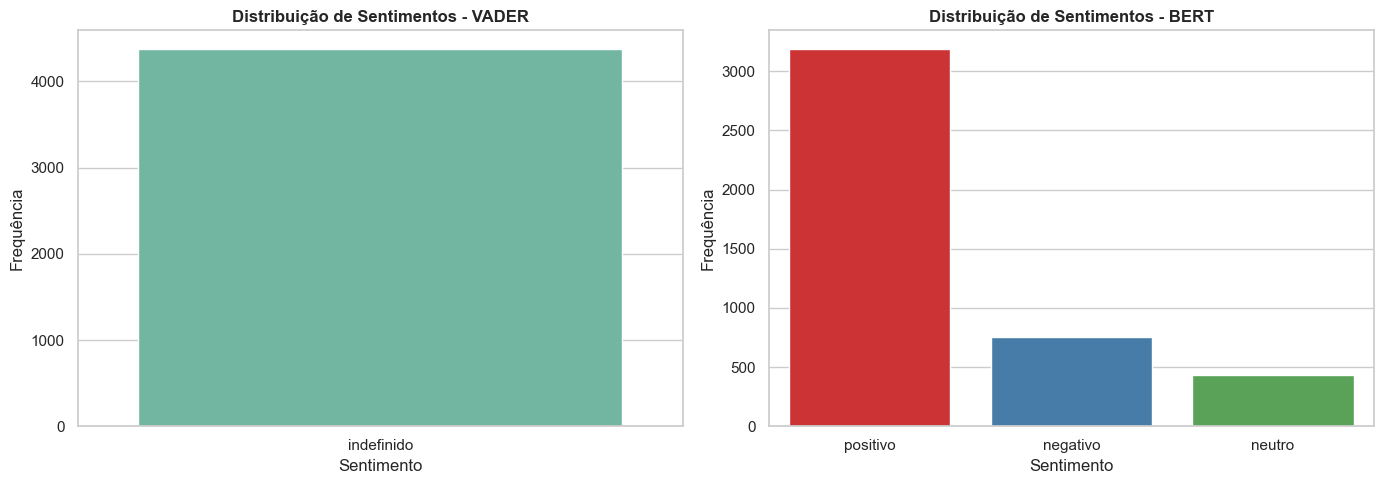

2025-11-23 19:11:13,177 - INFO - ✓ Gráficos gerados com sucesso


In [7]:
if not df.empty:
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Gráfico VADER
        if "vader_label" in df.columns:
            sns.countplot(data=df, x="vader_label", ax=axes[0], palette="Set2")
            axes[0].set_title("Distribuição de Sentimentos - VADER", fontsize=12, fontweight="bold")
            axes[0].set_xlabel("Sentimento")
            axes[0].set_ylabel("Frequência")
        
        # Gráfico BERT
        if "bert_label" in df.columns:
            sns.countplot(data=df, x="bert_label", ax=axes[1], palette="Set1")
            axes[1].set_title("Distribuição de Sentimentos - BERT", fontsize=12, fontweight="bold")
            axes[1].set_xlabel("Sentimento")
            axes[1].set_ylabel("Frequência")
        
        plt.tight_layout()
        plt.show()
        logger.info("✓ Gráficos gerados com sucesso")
        
    except Exception as e:
        logger.error(f"Erro ao gerar gráficos: {e}")
else:
    logger.warning("DataFrame vazio - não há dados para visualizar")

In [8]:
def salvar_resultados(df: pd.DataFrame, diretorio: str) -> Optional[str]:
    """
    Salva os resultados da análise em arquivo CSV.
    
    Args:
        df: DataFrame com os resultados
        diretorio: Diretório de destino
        
    Returns:
        Caminho do arquivo salvo ou None se houver erro
    """
    try:
        if df.empty:
            logger.warning("DataFrame vazio - nada para salvar")
            return None
        
        # Gerar timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        arquivo_saida = os.path.join(diretorio, f"comentarios_analisados_{timestamp}.csv")
        
        # Salvar
        df.to_csv(arquivo_saida, index=False, encoding="utf-8")
        
        tamanho_mb = os.path.getsize(arquivo_saida) / (1024 * 1024)
        logger.info(f"✓ Arquivo salvo com sucesso: {arquivo_saida}")
        logger.info(f"  Registros: {len(df)}")
        logger.info(f"  Colunas: {len(df.columns)}")
        logger.info(f"  Tamanho: {tamanho_mb:.2f} MB")
        
        return arquivo_saida
        
    except Exception as e:
        logger.error(f"Erro ao salvar resultados: {e}")
        return None

# Salvar resultados
if not df.empty:
    arquivo_salvo = salvar_resultados(df, RESULTADOS_DIR)
else:
    logger.warning("DataFrame vazio - pulando salvamento")

2025-11-23 19:11:13,269 - INFO - ✓ Arquivo salvo com sucesso: resultados\comentarios_analisados_20251123_191113.csv
2025-11-23 19:11:13,270 - INFO -   Registros: 4372
2025-11-23 19:11:13,271 - INFO -   Colunas: 12
2025-11-23 19:11:13,273 - INFO -   Tamanho: 1.04 MB
2025-11-23 19:11:13,270 - INFO -   Registros: 4372
2025-11-23 19:11:13,271 - INFO -   Colunas: 12
2025-11-23 19:11:13,273 - INFO -   Tamanho: 1.04 MB


## 📝 Conclusões

### Resumo da Análise
- **Total de comentários analisados:** (insira o número)
- **Período de coleta:** (insira as datas)
- **Modelos utilizados:** VADER e BERT (multilíngue)

### Principais Achados

#### Distribuição de Sentimentos
- **VADER:** (descreva a distribuição encontrada)
- **BERT:** (descreva a distribuição encontrada)

#### Concordância entre Modelos
- (Analise se VADER e BERT concordam ou discordam)
- (Quais são os casos de maior divergência?)

#### Insights Importantes
1. (Insight 1)
2. (Insight 2)
3. (Insight 3)

### Limitações e Considerações
- (Limitações encontradas)
- (Qualidade dos dados)
- (Possíveis melhorias futuras)